In [1]:
#%pip install matplotlib

In [2]:
import os
import json

import torch

from core.schemas import Config

from scripts.generate import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib notebook
reload_model = True

In [3]:
print(torch.__version__)

1.9.0


In [4]:
#sd = torch.load('./models/vqgan_imagenet_f16_16384.ckpt', map_location="cpu")["state_dict"]

In [5]:
CONFIG_FILE = './configs/local.json'
DEVICE = torch.device(os.environ.get("DEVICE", 'cuda' if torch.cuda.is_available() else 'cpu')) #

In [6]:
print(f"Loading default configuration from '{CONFIG_FILE}'")
with open(CONFIG_FILE, 'r') as f:
    PARAMS = Config(**json.load(f))
PARAMS.prompts = ['a painting of Claude Monet']
PARAMS.init_noise = 'gradient'
PARAMS.init_image = './samples/VanGogh.jpg'
print(f"Running on {DEVICE}.")
print(PARAMS)



Loading default configuration from './configs/local.json'
Saving outputs in './outputs'
Running on cuda.
Config:
  - prompts: ['a painting of Claude Monet']
  - image_prompts: []
  - max_iterations: 250
  - save_freq: 50
  - size: [256, 256]
  - pixelart: None
  - init_image: ./samples/VanGogh.jpg
  - init_noise: gradient
  - init_weight: 0.0
  - mse_decay_rate: 0
  - output_dir: ./outputs
  - models_dir: ./models
  - clip_model: ViT-B/16
  - vqgan_checkpoint: ./models/vqgan_imagenet_f16_16384.ckpt
  - vqgan_config: ./configs/models/vqgan_imagenet_f16_16384.json
  - noise_prompt_seeds: []
  - noise_prompt_weights: []
  - step_size: 0.1
  - cutn: 32
  - cut_pow: 1.0
  - seed: -1
  - optimizer: Adam
  - nwarm_restarts: -1
  - augments: ['Af', 'Pe', 'Ji', 'Er']



In [7]:

#global_seed(PARAMS.seed)
#model = load_vqgan_model(PARAMS.vqgan_config, PARAMS.vqgan_checkpoint, PARAMS.models_dir).to(DEVICE)




In [8]:
if reload_model:
    model = load_vqgan_model(PARAMS.vqgan_config, PARAMS.vqgan_checkpoint, PARAMS.models_dir).to(DEVICE)
    perceptor = clip.load(PARAMS.clip_model, device=DEVICE, root=PARAMS.models_dir)[0].eval().requires_grad_(False).to(DEVICE)
    cut_size = perceptor.visual.input_resolution
    make_cutouts = MakeCutouts(PARAMS.augments, cut_size, PARAMS.cutn, cut_pow=PARAMS.cut_pow)

    z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
    z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]
    reload_model = False


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Loaded pretrained VGG16 model from './models/vgg16-397923af.pth'
Loaded pretrained LPIPS loss from './models/vgg.pth'
VQLPIPSWithDiscriminator running with hinge loss.
1
./models/vqgan_imagenet_f16_16384.ckpt
Restored from ./models/vqgan_imagenet_f16_16384.ckpt
3
Augmentations: [RandomAffine(degrees=15, translate=0.1, scale=None, shear=15, resample=BILINEAR, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomPerspective(distortion_scale=0.5, interpolation=BILINEAR, align_corners=False, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False), RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0.0, p=0.5, p_batch=1.0, same_on_batch=False, return_transform=False)]


In [9]:
z = initialize_image(model, PARAMS)
z_orig = torch.zeros_like(z)
z.requires_grad_(True)

prompts = tokenize(model, perceptor, make_cutouts, PARAMS)
optimizer = get_optimizer(z, PARAMS.optimizer, PARAMS.step_size)
scheduler = get_scheduler(optimizer, PARAMS.max_iterations, PARAMS.nwarm_restarts)

kwargs = {
    'model': model,
    'perceptor': perceptor,
    'optimizer': optimizer,
    'scheduler': scheduler,
    'prompts': prompts,
    'make_cutouts': make_cutouts,
    'z_orig': z_orig,
    'z_min': z_min,
    'z_max': z_max,
    'mse_weight': PARAMS.init_weight,
}



<IPython.core.display.Javascript object>


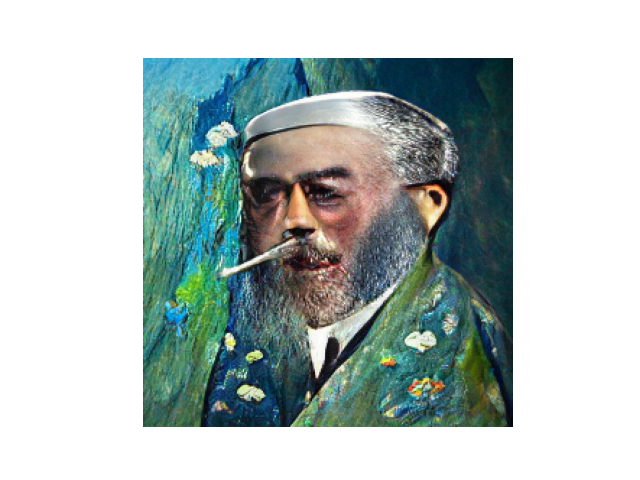

/opt/conda/lib/python3.7/site-packages/kornia/utils/helpers.py:96: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  out1, out2 = torch.solve(input.to(dtype), A.to(dtype))


step: 50, loss: 0.674488, losses: 0.674488
step: 100, loss: 0.650692, losses: 0.650692
step: 150, loss: 0.638485, losses: 0.638485
step: 200, loss: 0.649832, losses: 0.649832
step: 250, loss: 0.61779, losses: 0.61779



In [10]:
fig,ax = plt.subplots(1,1)

for step in tqdm(range(PARAMS.max_iterations)):
    kwargs['step'] = step + 1
    pil_image = train(z, PARAMS, **kwargs)
    if step % 5 == 0:
        ax.imshow(np.asarray(pil_image))
        plt.axis('off')
        fig.canvas.draw()
